In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.


(32 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
64 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
Dense 256 -> 
PReLU -> 
Dense 256 -> 
PReLU -> 
Dense 2) 

For different datasets we use a network with different number of input channels eg. MNIST or SVHN

<img src="./images/siamese.png" height="422" width="722" >

Contrastive loss function is given by the following :-

$$\mathcal{L}(I_{1}, I_{2}) = y[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]^{2} + (1-y)*ReLU([\mathcal{m}-[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]]^{2})$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [19]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [20]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import SiameseCD,SiameseMNIST,SiameseSVHN

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [21]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [22]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    
    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker='+', alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)
                
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [23]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [24]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 0.243391
Train: [12800/50000 (26%)]	Loss: 0.128969
Train: [25600/50000 (51%)]	Loss: 0.126224
Train: [38400/50000 (77%)]	Loss: 0.125497
Epoch: 1/20. Train set: Average loss: 0.1270
Epoch: 1/20. Validation set: Average loss: 0.1251
Train: [0/50000 (0%)]	Loss: 0.126083
Train: [12800/50000 (26%)]	Loss: 0.125463
Train: [25600/50000 (51%)]	Loss: 0.125437
Train: [38400/50000 (77%)]	Loss: 0.125213
Epoch: 2/20. Train set: Average loss: 0.1253
Epoch: 2/20. Validation set: Average loss: 0.1253
Train: [0/50000 (0%)]	Loss: 0.126909
Train: [12800/50000 (26%)]	Loss: 0.125392
Train: [25600/50000 (51%)]	Loss: 0.125128
Train: [38400/50000 (77%)]	Loss: 0.125098
Epoch: 3/20. Train set: Average loss: 0.1252
Epoch: 3/20. Validation set: Average loss: 0.1253
Train: [0/50000 (0%)]	Loss: 0.126344
Train: [12800/50000 (26%)]	Loss: 0.125433
Train: [25600/50000 (51%)]	Loss: 0.125133
Train: [38400/50000 (77%)]	Loss: 0.125075
Epoch: 4/20. Train set: Average loss: 0.1252
Epoch: 4/20. Valid

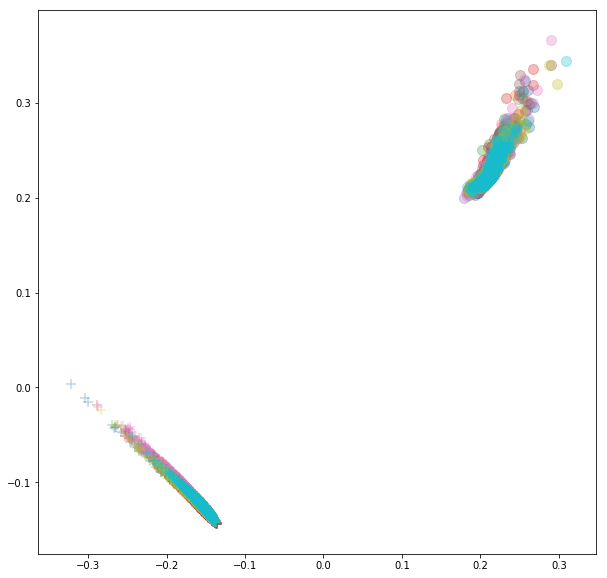

In [25]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model)
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model)


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

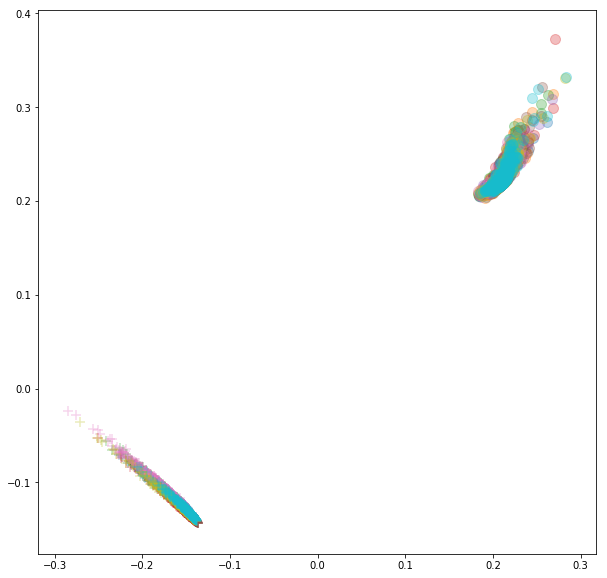

In [26]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model)
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model)


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [7]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)


siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [8]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [9]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 0.222626
Train: [12800/50000 (26%)]	Loss: 0.076109
Train: [25600/50000 (51%)]	Loss: 0.041451
Train: [38400/50000 (77%)]	Loss: 0.034525
Epoch: 1/20. Train set: Average loss: 0.0462
Epoch: 1/20. Validation set: Average loss: 0.0272
Train: [0/50000 (0%)]	Loss: 0.019524
Train: [12800/50000 (26%)]	Loss: 0.023814
Train: [25600/50000 (51%)]	Loss: 0.021563
Train: [38400/50000 (77%)]	Loss: 0.017530
Epoch: 2/20. Train set: Average loss: 0.0202
Epoch: 2/20. Validation set: Average loss: 0.0176
Train: [0/50000 (0%)]	Loss: 0.012106
Train: [12800/50000 (26%)]	Loss: 0.014716
Train: [25600/50000 (51%)]	Loss: 0.012268
Train: [38400/50000 (77%)]	Loss: 0.012977
Epoch: 3/20. Train set: Average loss: 0.0128
Epoch: 3/20. Validation set: Average loss: 0.0157
Train: [0/50000 (0%)]	Loss: 0.029076
Train: [12800/50000 (26%)]	Loss: 0.008927
Train: [25600/50000 (51%)]	Loss: 0.009646
Train: [38400/50000 (77%)]	Loss: 0.008889
Epoch: 4/20. Train set: Average loss: 0.0090
Epoch: 4/20. Valid

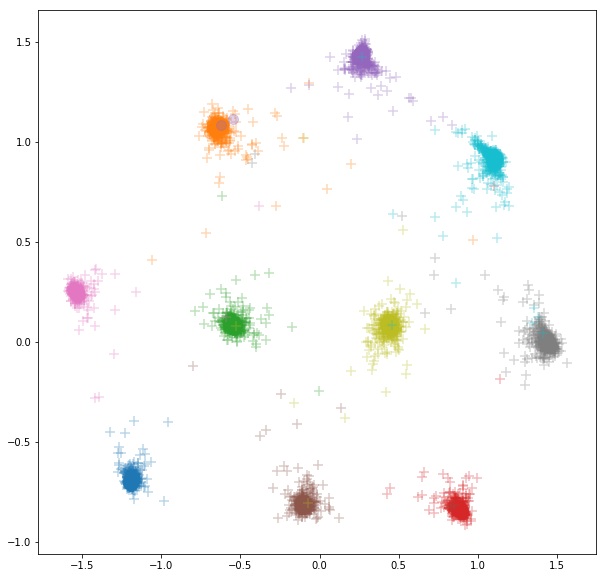

In [16]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model)
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model)


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

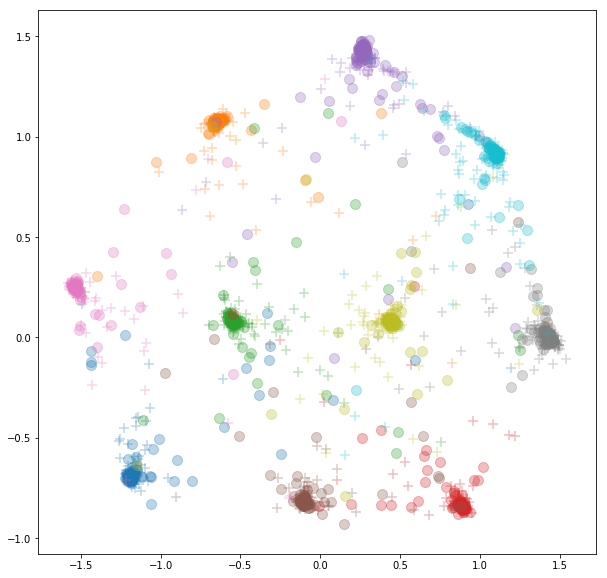

In [17]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model)
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model)


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Online Pair Selection 

 We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)